In [1]:
from read_data.quikscat_daily_v4 import QuikScatDaily
import os
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import RegularGridInterpolator

# 設置文件夾保存圖像
output_folder = "QuikSAT_images"
os.makedirs(output_folder, exist_ok=True)

#### 手動調整

In [2]:
# 設定範圍和條件
# 將日期定義為變量
date = "20040623"
dtype = "test_data"

# 定义经纬度范围
lon1, lon2 = 120, 130
lat1, lat2 = 10, 20

In [3]:
dataset = QuikScatDaily(f"{dtype}/qscat_{date}v4.gz")

# ascending or descending pass
path = 0

# 讀取數據
latitude = dataset.variables['latitude'][:]  # 緯度 (160,)
longitude = dataset.variables['longitude'][:]  # 經度 (120,)
wind_speed = dataset.variables['windspd'][:][path]  # 風速
wind_dir = dataset.variables['winddir'][:][path]  # 風向
scatflag = dataset.variables['scatflag'][:][path] 

print("latitude shape",latitude.shape)
print("longitude shape",longitude.shape)
print("wind_speed shape",wind_speed.shape)
print("wind_dir shape",wind_dir.shape)
print("scatflag shape",scatflag.shape)


# 限制範圍：125°E - 155°E, 0°N - 40°N
lon_min, lon_max = 125, 155
lat_min, lat_max = 0, 40

lon_idx = (longitude >= lon_min) & (longitude <= lon_max)
lat_idx = (latitude >= lat_min) & (latitude <= lat_max)

longitude = longitude[lon_idx]
latitude = latitude[lat_idx]
wind_speed = wind_speed[lat_idx, :][ :, lon_idx]
wind_dir = wind_dir[lat_idx, :][:, lon_idx]
scatflag_mask = scatflag[lat_idx, :][:, lon_idx]

# 設定範圍
lon_grid, lat_grid = np.meshgrid(longitude, latitude)

# 計算風的分量
u = np.cos(np.deg2rad(wind_dir))  # 統一箭頭大小，無關風速
v = np.sin(np.deg2rad(wind_dir))

print('---after indexing---')
print("latitude shape",latitude.shape)
print("longitude shape",longitude.shape)
print("wind_speed shape",wind_speed.shape)
print("wind_dir shape",wind_dir.shape)
print("scatflag shape",scatflag.shape)

latitude shape (720,)
longitude shape (1440,)
wind_speed shape (720, 1440)
wind_dir shape (720, 1440)
scatflag shape (720, 1440)
---after indexing---
latitude shape (160,)
longitude shape (120,)
wind_speed shape (160, 120)
wind_dir shape (160, 120)
scatflag shape (720, 1440)


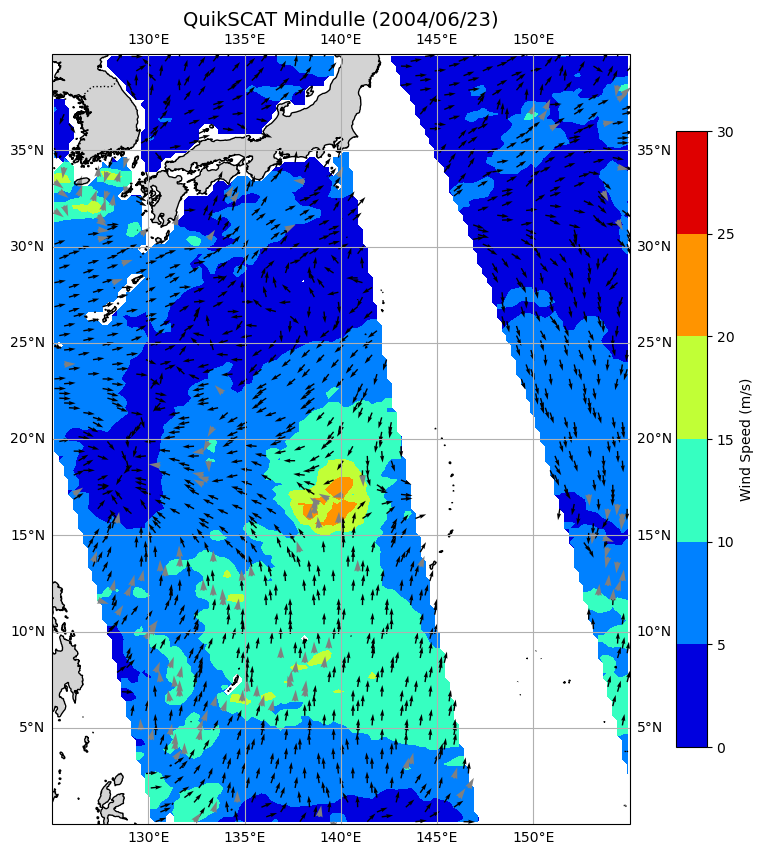

In [8]:
# 繪製圖像
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 10))
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# 繪製風速等高線
contour = ax.contourf(
    lon_grid, lat_grid, wind_speed,
    levels=np.arange(0, 35, 5), cmap='jet', transform=ccrs.PlateCarree()
)
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, shrink=0.8)
cbar.set_label("Wind Speed (m/s)")

# 繪製風向箭頭（黑色代表陸地，灰色代表水域）
# 計算風向分量，統一箭頭長度
u_normalized = np.cos(np.deg2rad(wind_dir))  # 固定為單位向量
v_normalized = np.sin(np.deg2rad(wind_dir))

# 繪製風向箭頭（黑色代表陸地，灰色代表水域）
for scatflag_value, color in [(0, 'black'), (1, 'gray')]:  # 1=陸地, 0=水域
    mask = scatflag_mask == scatflag_value
    masked_lon = lon_grid[mask]
    masked_lat = lat_grid[mask]
    u_masked = u_normalized[mask]
    v_masked = v_normalized[mask]

    # 適當減少箭頭密度
    ax.quiver(
        masked_lon[::10], masked_lat[::10],  # 經緯度位置
        u_masked[::10], v_masked[::10],     # 統一長度的風向分量
        scale=50, color=color, transform=ccrs.PlateCarree()  # 設定 scale 控制箭頭大小
    )

# 添加地圖特徵
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, color='lightgray')  # 陸地顏色
ax.add_feature(cfeature.OCEAN, color='white')  # 海洋顏色
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# 添加標題
plt.title("QuikSCAT Mindulle (2004/06/23)", fontsize=14)
plt.savefig(output_folder + f'/quiksat_{date}.png', dpi=300)
plt.show()